# Market Test in Jupyter

# SQL for Res Sales


In [19]:
import pyodbc
import pandas as pd

### Connections: Database

# Configuration for database connection
db_connection_string = (
    "Driver={SQL Server};"
    "Server=astxdbprod;"
    "Database=GRM_Main;"
    "Trusted_Connection=yes;"
)

# Function to connect to the database
def connect_to_database(connection_string):
    try:
        connection = pyodbc.connect(connection_string)
        print("Connection successful.")
        return connection
    except Exception as e:
        print("Error connecting to database:", e)
        return None


# The query should accommodate multiple AINs in a list
query = """
/*
-- !preview conn=conn
*/

/*
AsTxDBProd
GRM_Main
*/

-------------------------------------
-- RESIDENTIAL, COMMERCIAL and/or Manufactered Homes WORKSHEETS
-------------------------------------

/*
Residential, Commercial, and Manufactered Homes share same query with different filters/steps
Change the following:

SELECT statements should be 'res.','comm.', or 'mh.', comment out the others acccordingly.

--MH must keep res. and mh., res. is for Floathomes which are drawn in as regular stick homes.

--Commercial and MH may want columns removed that aren't used. 
  Can be done in SQL or "remove columns" steo in Power Query
  Benefit of doing it inside Power Query,
    when you update the year, you can paste the code and the columns will stay edited,
    whereas, doing it in SQL will cause you to lose that code, unless you comment out instead of delete

WHERE Conditions comment out the two you aren't using.

*/

Declare @Year int = 2024; -- Input THIS year here
--DECLARE @TaxYear INT;
--SET @TaxYear = YEAR(GETDATE());

Declare @YearPrev int = @Year - 1; -- Input the year here
Declare @YearPrevPrev int = @Year - 2; -- Input the year here


Declare @MemoLastUpdatedNoEarlierThan date = CAST(CAST(@Year as varchar) + '-01-01' AS DATE); -- Generates '2023-01-01' for the current year
--Declare @MemoLastUpdatedNoEarlierThan DATE = '2024-01-01';
--1/1 of the earliest year requested. 
-- If you need sales back to 10/01/2022, use 01/01/2022

Declare @PrimaryTransferDateFROM date = CAST(CAST(@Year as varchar) + '-01-01' AS DATE); -- Generates '2023-01-01' for the current year
Declare @PrimaryTransferDateTO date = CAST(CAST(@Year as varchar) + '-12-31' AS DATE); -- Generates '2023-01-01' for the current year
--Declare @PrimaryTransferDateFROM DATE = '2024-01-01';
--Declare @PrimaryTransferDateTO DATE = '2024-12-31';
--pxfer_date
--AND tr.pxfer_date BETWEEN '2023-01-01' AND '2023-12-31'

Declare @CertValueDateFROM varchar(8) = Cast(@Year as varchar) + '0101'; -- Generates '20230101' for the previous year
Declare @CertValueDateTO varchar(8) = Cast(@Year as varchar) + '1231'; -- Generates '20230101' for the previous year
--Declare @CertValueDateFROM INT = '20240101';
--Declare @CertValueDateTO INT = '20241231';
--v.eff_year
---WHERE v.eff_year BETWEEN 20230101 AND 20231231


Declare @LandModelId varchar(6) = '70' + Cast(@Year as varchar); -- Generates '702023' for the previous year
    --AND lh.LandModelId='702023'
    --AND ld.LandModelId='702023'
    --AND lh.LandModelId= @LandModelId
    --AND ld.LandModelId= @LandModelId 





-------------------------------------
-- CTEs will drive this report and combine in the main query
-------------------------------------
WITH

-------------------------------------
--CTE_MarketAdjustmentNotes 
-- Using the memos table with SA and SAMH memo_id
--NOTES, CONCAT allows one line of notes instead of duplicate rows, TRIM removes spaces from boths ides
-------------------------------------
-------------------------------------
--CTE_ParcelMasterData
-------------------------------------
CTE_ParcelMasterData AS (
  Select Distinct
  pm.lrsn,
  LTRIM(RTRIM(pm.pin)) AS [PIN],
  LTRIM(RTRIM(pm.AIN)) AS [AIN],
  pm.neighborhood AS [GEO],
  LTRIM(RTRIM(pm.NeighborHoodName)) AS [GEO_Name],
  LTRIM(RTRIM(pm.PropClassDescr)) AS [PCC_ClassCD],
  LTRIM(RTRIM(pm.SitusAddress)) AS [SitusAddress],
  LTRIM(RTRIM(pm.SitusCity)) AS [SitusCity],
  pm.LegalAcres,
  pm.Improvement_Status,
  pm.WorkValue_Land,
  pm.WorkValue_Impv,
  pm.WorkValue_Total
  
  From TSBv_PARCELMASTER AS pm
  --Where pm.EffStatus = 'A'
  
  ),
  
-------------------------------------
--CTE_TransferSales
-------------------------------------
CTE_DocCounts AS (
  SELECT 
    DocNum,
    COUNT(DocNum) AS NumOccurrences
  FROM transfer
  WHERE status = 'A'
    AND AdjustedSalePrice <> '0'
    AND pxfer_date BETWEEN @PrimaryTransferDateFROM AND @PrimaryTransferDateTO
  GROUP BY DocNum
),

CTE_TransferSales AS (
SELECT DISTINCT
  t.lrsn
  ,TRIM(t.GrantorName) GrantorName
  ,TRIM(t.GranteeName) GranteeName
  ,t.status
  ,t.AdjustedSalePrice AS SalePrice
  ,CAST(t.pxfer_date AS DATE) AS SaleDate
  ,TRIM(t.SaleDesc) AS SaleDescr
  ,CASE 
    WHEN dc.NumOccurrences > 1 THEN 'M' 
    ELSE 'S' 
  END AS TranxType
  ,TRIM(t.DocNum) AS DocNumber
FROM transfer AS t
JOIN CTE_DocCounts AS dc ON t.DocNum = dc.DocNum
WHERE t.status = 'A'
  AND t.AdjustedSalePrice <> '0'
  AND t.pxfer_date BETWEEN @PrimaryTransferDateFROM AND @PrimaryTransferDateTO
  AND t.deed_type = 'fu'
),

-------------------------------------
--CTE_CertValues
-------------------------------------
CTE_CertValues AS (
  SELECT 
    v.lrsn,
    --Certified Values
    v.land_market_val AS [Certified_Land],
    v.imp_val AS [Certified_Imp],
    (v.imp_val + v.land_market_val) AS [Certified_TotalValue],
    v.eff_year AS [Tax_Year],
    ROW_NUMBER() OVER (PARTITION BY v.lrsn ORDER BY v.last_update DESC) AS RowNumber
  FROM valuation AS v
  --WHERE v.eff_year BETWEEN 20230101 AND 20231231
  WHERE v.eff_year BETWEEN @CertValueDateFROM AND @CertValueDateTO

  
--Change to desired year
    AND v.status = 'A'
),


CTE_NotesSalesAnalysis AS (
SELECT
  lrsn,
  STRING_AGG(memo_text, ' | ') AS Sales_Notes
FROM memos

WHERE status = 'A'
AND memo_id IN ('SA', 'SAMH')
AND memo_line_number <> '1'
AND last_update >= @MemoLastUpdatedNoEarlierThan

/*
AND (memo_text LIKE '%/23 %'
    OR memo_text LIKE '%/2023 %'
    OR memo_text LIKE '%/24 %'
    OR memo_text LIKE '%/2024 %')
*/
GROUP BY lrsn
),

-------------------------------------
--CTE_MarketAdjustmentNotes 
-- Using the memos table with SA and SAMH memo_id
--NOTES, CONCAT allows one line of notes instead of duplicate rows, TRIM removes spaces from boths ides
-------------------------------------

CTE_NotesConfidential AS (
SELECT
  lrsn,
  STRING_AGG(memo_text, ' | ') AS Conf_Notes
FROM memos

WHERE status = 'A'
AND memo_id IN ('NOTE')
AND memo_line_number <> '1'
AND last_update >= @MemoLastUpdatedNoEarlierThan

/*
AND (memo_text LIKE '%/23 %'
    OR memo_text LIKE '%/2023 %'
    OR memo_text LIKE '%/24 %'
    OR memo_text LIKE '%/2024 %')
*/
GROUP BY lrsn

),

-------------------------------------
--CTE_Improvements_Residential
-------------------------------------
CTE_Improvements_Residential AS (
----------------------------------
-- View/Master Query: Always e > i > then finally mh, cb, dw
----------------------------------
  Select Distinct
  --Extensions Table
  e.lrsn,
  e.extension,
  e.ext_description,
  e.data_collector,
  e.collection_date,
  e.appraiser,
  e.appraisal_date,
  --Improvements Table
    --codes_table 
    --AND park.tbl_type_code='grades'
  i.imp_type,
  i.year_built,
  i.eff_year_built,
  i.year_remodeled,
  i.condition,
  i.grade AS [GradeCode], -- is this a code that needs a key?
  grades.tbl_element_desc AS [GradeType],
  
  -- Residential Dwellings dw
    --codes_table
    -- AND htyp.tbl_type_code='htyp'  
  STRING_AGG(dw.mkt_house_type, ' | ') AS [HouseType#],
  STRING_AGG(htyp.tbl_element_desc, ' | ')  AS [HouseTypeName],
  --dw.mkt_house_type AS [HouseType#],
  --htyp.tbl_element_desc AS [HouseTypeName],
  dw.mkt_rdf AS [RDF], -- Relative Desirability Facotor (RDF), see ProVal, Values, Cost Buildup, under depreciation
  ROW_NUMBER() OVER (PARTITION BY e.lrsn ORDER BY e.extension ASC) AS RowNum

  
  --Extensions always comes first
  FROM extensions AS e -- ON e.lrsn --lrsn link if joining this to another query
    -- AND e.status = 'A' -- Filter if joining this to another query
  JOIN improvements AS i ON e.lrsn=i.lrsn 
        AND e.extension=i.extension
        AND i.status='A'
        AND i.improvement_id IN ('M','C','D')
      --need codes to get the grade name, vs just the grade code#
      LEFT JOIN codes_table AS grades ON i.grade = grades.tbl_element
        AND grades.tbl_type_code='grades'
  --manuf_housing, comm_bldg, dwellings all must be after e and i
  --RESIDENTIAL DWELLINGS
  LEFT JOIN dwellings AS dw ON i.lrsn=dw.lrsn
        AND dw.status='A'
        AND i.extension=dw.extension
    LEFT JOIN codes_table AS htyp ON dw.mkt_house_type = htyp.tbl_element 
      AND htyp.tbl_type_code='htyp'  
       
  --MANUFACTERED HOUSING
  LEFT JOIN manuf_housing AS mh ON i.lrsn=mh.lrsn 
        AND i.extension=mh.extension
        AND mh.status='A'
    LEFT JOIN codes_table AS make ON mh.mh_make=make.tbl_element 
      AND make.tbl_type_code='mhmake'
    LEFT JOIN codes_table AS model ON mh.mh_model=model.tbl_element 
      AND model.tbl_type_code='mhmodel'
    LEFT JOIN codes_table AS park ON mh.mhpark_code=park.tbl_element 
      AND park.tbl_type_code='mhpark'
  
  --Conditions
  WHERE e.status = 'A'
  AND i.improvement_id IN ('D','M')
  AND (e.ext_description LIKE '%H1%'
    OR e.ext_description LIKE '%H-1%'
    OR e.ext_description LIKE '%NREV%'
    OR e.ext_description LIKE '%FLOAT%'
    OR e.ext_description LIKE '%BOAT%'
       )
  GROUP BY
  e.lrsn,
  e.extension,
  e.ext_description,
  e.data_collector,
  e.collection_date,
  e.appraiser,
  e.appraisal_date,
  i.imp_type,
  i.year_built,
  i.eff_year_built,
  i.year_remodeled,
  i.condition,
  i.grade,
  grades.tbl_element_desc,
  dw.mkt_rdf

),

-------------------------------------
--CTE_Improvements_Commercial
-------------------------------------
CTE_Improvements_Commercial AS (
----------------------------------
-- View/Master Query: Always e > i > then finally mh, cb, dw
-- IN JOIN for Commercial, ensure AND RowNum = 1
----------------------------------

  Select Distinct
  --Extensions Table
  e.lrsn,
  e.extension,
  e.ext_description,
  e.data_collector,
  e.collection_date,
  e.appraiser,
  e.appraisal_date,
  --Improvements Table
    --codes_table 
    --AND park.tbl_type_code='grades'
  i.imp_type,
  --Commercial
  STRING_AGG(cu.use_code, ',') AS use_codes,
  i.year_built,
  i.eff_year_built,
  i.year_remodeled,
  i.condition,
  i.grade AS [GradeCode], -- is this a code that needs a key?
  grades.tbl_element_desc AS [GradeType],
  ROW_NUMBER() OVER (PARTITION BY e.lrsn ORDER BY e.extension ASC) AS RowNum
  
  --Extensions always comes first
  FROM extensions AS e -- ON e.lrsn --lrsn link if joining this to another query
    -- AND e.status = 'A' -- Filter if joining this to another query
  JOIN improvements AS i ON e.lrsn=i.lrsn 
        AND e.extension=i.extension
        AND i.status='A'
        AND i.improvement_id IN ('M','C','D')
      --need codes to get the grade name, vs just the grade code#
      LEFT JOIN codes_table AS grades ON i.grade = grades.tbl_element
        AND grades.tbl_type_code='grades'
  --manuf_housing, comm_bldg, dwellings all must be after e and i
  --COMMERCIAL      
  LEFT JOIN comm_bldg AS cb ON i.lrsn=cb.lrsn 
        AND i.extension=cb.extension
        AND cb.status='A'
      LEFT JOIN comm_uses AS cu ON cb.lrsn=cu.lrsn
        AND cb.extension = cu.extension
        AND cu.status='A'
  
  WHERE e.status = 'A'
  AND i.improvement_id IN ('C')
  
  GROUP BY
  e.lrsn,
  e.extension,
  e.ext_description,
  e.data_collector,
  e.collection_date,
  e.appraiser,
  e.appraisal_date,
  i.imp_type,
  i.year_built,
  i.eff_year_built,
  i.year_remodeled,
  i.condition,
  i.grade,
  grades.tbl_element_desc
),

-------------------------------------
--CTE_Improvements_MH Manufactered Home
-------------------------------------
CTE_Improvements_MH AS (
----------------------------------
-- View/Master Query: Always e > i > then finally mh, cb, dw
----------------------------------
  Select Distinct
  --Extensions Table
  e.lrsn,
  e.extension,
  e.ext_description,
  e.data_collector,
  e.collection_date,
  e.appraiser,
  e.appraisal_date,
  
  --Improvements Table
    --codes_table 
    --AND park.tbl_type_code='grades'
  i.imp_type,
  i.year_built,
  i.eff_year_built,
  i.year_remodeled,
  i.condition,
  i.grade AS [GradeCode], -- is this a code that needs a key?
  grades.tbl_element_desc AS [GradeType],
  
  -- Residential Dwellings dw
    --codes_table
    -- AND htyp.tbl_type_code='htyp'  
  dw.mkt_house_type AS [HouseType#],
  htyp.tbl_element_desc AS [HouseTypeName],
  dw.mkt_rdf AS [RDF], -- Relative Desirability Facotor (RDF), see ProVal, Values, Cost Buildup, under depreciation
  
  --Commercial
  cu.use_code,
  
  --manuf_housing
      --codes_table 
      --AND make.tbl_type_code='mhmake'
      --AND model.tbl_type_code='mhmodel'    
      --AND park.tbl_type_code='mhpark'
  mh.mh_make AS [MHMake#],
  make.tbl_element_desc AS [MH_Make],
  mh.mh_model AS [MHModel#],
  model.tbl_element_desc AS [MH_Model],
  mh.mh_serial_num AS [VIN],
  mh.mhpark_code,
  park.tbl_element_desc AS [MH_Park]
  
  --Extensions always comes first
  FROM extensions AS e -- ON e.lrsn --lrsn link if joining this to another query
    -- AND e.status = 'A' -- Filter if joining this to another query
  JOIN improvements AS i ON e.lrsn=i.lrsn 
        AND e.extension=i.extension
        AND i.status='A'
        AND i.improvement_id IN ('M','C','D')
      --need codes to get the grade name, vs just the grade code#
      LEFT JOIN codes_table AS grades ON i.grade = grades.tbl_element
        AND grades.tbl_type_code='grades'
        
  --manuf_housing, comm_bldg, dwellings all must be after e and i
  
  --COMMERCIAL      
  LEFT JOIN comm_bldg AS cb ON i.lrsn=cb.lrsn 
        AND i.extension=cb.extension
        AND cb.status='A'
      LEFT JOIN comm_uses AS cu ON cb.lrsn=cu.lrsn
        AND cb.extension = cu.extension
        AND cu.status='A'
        
  --RESIDENTIAL DWELLINGS
  LEFT JOIN dwellings AS dw ON i.lrsn=dw.lrsn
        AND dw.status='A'
        AND i.extension=dw.extension
    LEFT JOIN codes_table AS htyp ON dw.mkt_house_type = htyp.tbl_element 
      AND htyp.tbl_type_code='htyp'  
       
  --MANUFACTERED HOUSING
  LEFT JOIN manuf_housing AS mh ON i.lrsn=mh.lrsn 
        AND i.extension=mh.extension
        AND mh.status='A'
    LEFT JOIN codes_table AS make ON mh.mh_make=make.tbl_element 
      AND make.tbl_type_code='mhmake'
    LEFT JOIN codes_table AS model ON mh.mh_model=model.tbl_element 
      AND model.tbl_type_code='mhmodel'
    LEFT JOIN codes_table AS park ON mh.mhpark_code=park.tbl_element 
      AND park.tbl_type_code='mhpark'
      
  WHERE e.status = 'A'
  AND i.improvement_id IN ('M')

),


-------------------------------------
-- CTE_MultiSaleSums
-------------------------------------
-- Common Table Expression (CTE) to calculate the sums for Multi-Sale cases
CTE_MultiSaleSums AS (
  SELECT
    t.DocNum,
    SUM(cv23.[Certified_Land]) AS [MultiSale_Land],
    SUM(cv23.[Certified_Imp]) AS [MultiSale_Imp],
    SUM(cv23.Certified_TotalValue) AS [MultiSale_TotalSums],
    SUM(pm.WorkValue_Impv) AS [MultiSale_WorksheetImp]
  FROM transfer AS t -- ON t.lrsn for joins
  JOIN CTE_CertValues AS cv23 ON t.lrsn=cv23.lrsn
  JOIN CTE_ParcelMasterData AS pm ON t.lrsn=pm.lrsn

  WHERE
    t.TfrType = 'M' -- Filter only Multi-Sale cases
  GROUP BY
    t.DocNum
),

  
-------------------------------------
-- CTE_Cat19Waste
-------------------------------------
CTE_Cat19Waste AS (
  SELECT
  lh.RevObjId AS [lrsn],
  ld.LandDetailType,
  ld.LandType,
  lt.land_type_desc,
  ld.SoilIdent,
  ld.LDAcres AS [Cat19Waste]
  
  --Land Header
  FROM LandHeader AS lh
  --Land Detail
  JOIN LandDetail AS ld ON lh.id=ld.LandHeaderId 
    AND ld.EffStatus='A' 
    AND lh.PostingSource=ld.PostingSource
  --Land Types
  LEFT JOIN land_types AS lt ON ld.LandType=lt.land_type
  
  WHERE lh.EffStatus= 'A' 
    AND lh.PostingSource='A'
    AND ld.PostingSource='A'
  --Change land model id for current year
    --AND lh.LandModelId='702023'
    --AND ld.LandModelId='702023'
    AND lh.LandModelId= @LandModelId
    AND ld.LandModelId= @LandModelId 
  --Looking for:
    AND ld.LandType IN ('82')
    
),

-------------------------------------
-- CTE_LandDetails
-------------------------------------

CTE_LandDetails AS (
  SELECT
  lh.RevObjId AS [lrsn],
  ld.LandDetailType,
  ld.lcm,
  ld.LandType,
  lt.land_type_desc,
  ld.SoilIdent,
  ld.LDAcres,
  ld.ActualFrontage,
  ld.DepthFactor,
  ld.SoilProdFactor,
  ld.SmallAcreFactor,
  ld.SiteRating,
  TRIM (sr.tbl_element_desc) AS [Legend],
ROW_NUMBER() OVER (PARTITION BY lh.RevObjId ORDER BY sr.tbl_element_desc ASC) AS [RowNumber],
  li.InfluenceCode,
  STRING_AGG (li.InfluenceAmount, ',') AS [InfluenceFactor(s)],
  li.InfluenceAmount,
  CASE
      WHEN li.InfluenceType = 1 THEN '1-Pct'
      ELSE '2-Val'
  END AS [InfluenceType],
  li.PriceAdjustment
  
  --Land Header
  FROM LandHeader AS lh
  --Land Detail
  JOIN LandDetail AS ld ON lh.id=ld.LandHeaderId 
    AND ld.EffStatus='A' 
    AND ld.PostingSource='A'
    AND lh.PostingSource=ld.PostingSource
  LEFT JOIN codes_table AS sr ON ld.SiteRating = sr.tbl_element
      AND sr.tbl_type_code='siterating  '

  --Land Types
  LEFT JOIN land_types AS lt ON ld.LandType=lt.land_type
  
  --Land Influence
  LEFT JOIN LandInfluence AS li ON li.ObjectId = ld.Id
    AND li.EffStatus='A' 
    AND li.PostingSource='A'

  
  WHERE lh.EffStatus= 'A' 
    AND lh.PostingSource='A'

  --Change land model id for current year
    --AND lh.LandModelId='702023'
    --AND ld.LandModelId='702023'
    AND lh.LandModelId= @LandModelId
    AND ld.LandModelId= @LandModelId 
    AND ld.LandType IN ('9','31','32')

  --Looking for:
    --AND ld.LandType IN ('82')
    GROUP BY
  lh.RevObjId,
  ld.LandDetailType,
  ld.lcm,
  ld.LandType,
  lt.land_type_desc,
  ld.SoilIdent,
  ld.LDAcres,
  ld.ActualFrontage,
  ld.DepthFactor,
  ld.SoilProdFactor,
  ld.SmallAcreFactor,
  ld.SiteRating,
  sr.tbl_element_desc,
  li.InfluenceCode,
  li.InfluenceAmount,
  li.InfluenceType,
  li.PriceAdjustment
    
),

-----------------------
--CTE_LandDetailsRemAcre pulls the LCM and Land Type for only Remaining Acres legends.
-----------------------
CTE_LandDetailsRemAcre AS (
  SELECT
  lh.RevObjId AS [lrsn]
  ,ld.LandDetailType
  ,ld.lcm
  ,ld.LandType
  ,ld.LDAcres
  ,ld.BaseRate
  --Land Header
  FROM LandHeader AS lh
  --Land Detail
  JOIN LandDetail AS ld ON lh.id=ld.LandHeaderId 
    AND ld.EffStatus='A' 
    AND ld.PostingSource='A'
    AND lh.PostingSource=ld.PostingSource
  LEFT JOIN codes_table AS sr ON ld.SiteRating = sr.tbl_element
      AND sr.tbl_type_code='siterating'

WHERE ld.LandType IN ('91')
AND ld.lcm IN ('3','30')
),

-----------------------
--CTE_CommBldgSF pulls in Commercial SF for a $/SF Rate
-----------------------
CTE_CommBldgSF AS (
  SELECT
    lrsn,
    SUM(area) AS [CommSF]
  FROM comm_uses
  WHERE status = 'A'
  GROUP BY lrsn
  
),

CTE_CommBldMultiSaleSF AS (
  SELECT
    t.DocNum,
    SUM(cbsf.[CommSF]) AS [CommBldMultiSaleSF]
    
    --bring in this table
    
  FROM
    transfer AS t -- ON t.lrsn for joins
    
  JOIN CTE_CommBldgSF AS cbsf ON t.lrsn=cbsf.lrsn

  WHERE
    t.TfrType = 'M' -- Filter only Multi-Sale cases
  GROUP BY
    t.DocNum
)


-------------------------------------
-- End of CTEs
-------------------------------------

-------------------------------------
--START Primary Qeury, Driven by Transfer Table
--FROM Transfer table, JOIN CTEs
-------------------------------------
SELECT DISTINCT
  CASE
        WHEN pmd.GEO >= 9000 THEN 'Manufactured_Homes'
        WHEN pmd.GEO >= 6003 THEN 'District_6'
        WHEN pmd.GEO = 6002 THEN 'Manufactured_Homes'
        WHEN pmd.GEO = 6001 THEN 'District_6'
        WHEN pmd.GEO = 6000 THEN 'Manufactured_Homes'
        WHEN pmd.GEO >= 5003 THEN 'District_5'
        WHEN pmd.GEO = 5002 THEN 'Manufactured_Homes'
        WHEN pmd.GEO = 5001 THEN 'District_5'
        WHEN pmd.GEO = 5000 THEN 'Manufactured_Homes'
        WHEN pmd.GEO >= 4000 THEN 'District_4'
        WHEN pmd.GEO >= 3000 THEN 'District_3'
        WHEN pmd.GEO >= 2000 THEN 'District_2'
        WHEN pmd.GEO >= 1021 THEN 'District_1'
        WHEN pmd.GEO = 1020 THEN 'Manufactured_Homes'
        WHEN pmd.GEO >= 1001 THEN 'District_1'
        WHEN pmd.GEO = 1000 THEN 'Manufactured_Homes'
        WHEN pmd.GEO >= 451 THEN 'Commercial'
        WHEN pmd.GEO = 450 THEN 'Specialized_Cell_Towers'
        WHEN pmd.GEO >= 1 THEN 'Commercial'
        WHEN pmd.GEO = 0 THEN 'N/A_or_Error'
        ELSE NULL
    END AS District,
-- # District SubClass
CASE
    --Commercial # Income properties use regular template, for now. 
    --  May build something. Set up just in case. DGW 08/02/2023.
      WHEN pmd.GEO BETWEEN '1' AND '27' THEN 'Comm_Sales'
      WHEN pmd.GEO = '28' THEN 'Comm_Sales' -- < -- Income properties but use regular template, for now. 08/02/2023
      WHEN pmd.GEO BETWEEN '29' AND '41' THEN 'Comm_Sales'
      WHEN pmd.GEO = '41' THEN 'Comm_Sales'
      WHEN pmd.GEO = '42' THEN 'Section42_Workbooks'
      WHEN pmd.GEO = '43' THEN 'Comm_Sales'
      WHEN pmd.GEO = '44' THEN 'Comm_Sales' -- < -- Income properties but use regular template, for now. 08/02/2023
      WHEN pmd.GEO BETWEEN '45' AND '99' THEN 'Comm_Sales'
      WHEN pmd.GEO BETWEEN '100' AND '199' THEN 'Comm_Waterfront'
      WHEN pmd.GEO BETWEEN '200' AND '899' THEN 'Comm_Sales'
    --D1
      WHEN pmd.GEO IN ('1008','1010','1410','1420','1430','1430','1440','1450','1501','1502','1503','1505','1506','1507') THEN 'Res_Waterfront'
      WHEN pmd.GEO IN ('1998','1999') THEN 'Res_MultiFamily'
    --D2
      WHEN pmd.GEO IN ('2105','2115','2125','2135','2145','2155') THEN 'Res_Waterfront'
      WHEN pmd.GEO IN ('2996','2997','2998','2999') THEN 'Res_MultiFamily'
    --D3
      WHEN pmd.GEO IN ('3502','3503','3504','3505','3506') THEN 'Res_Waterfront'
      WHEN pmd.GEO IN ('3998','3999') THEN 'Res_MultiFamily'
    --D4
      WHEN pmd.GEO IN ('4201','4202','4203','4204','1430','1430','1440','1450','1501','1502','1503','1505','1506','1507') THEN 'Res_Waterfront'
      WHEN pmd.GEO IN ('4833','4840','4997','4998','4999') THEN 'Res_MultiFamily'
    --D5
      WHEN pmd.GEO IN ('5001','5004','5009','5010','5012','5015','5018','5020','5021','5024','5030','5033','5036','5039',
                                '5042','5045','5048','5051','5053','5054','5056','5057','5060','5063','5066','5069','5072','5075','5078',
                                '5081','5750','5753','5756','5759','5762','5765','5850','5853','5856') THEN 'Res_Waterfront'
      -- WHEN pmd.GEO IN ('','') THEN 'Res_MutliFamily' -- No MultiFamily in D5 as of 08/02/2023
    --D6
      WHEN pmd.GEO BETWEEN '6100' AND '6123' THEN 'Res_Waterfront'
      -- WHEN pmd.GEO IN ('','') THEN 'Res_MutliFamily' -- No MultiFamily in D6 as of 08/02/2023
    -- MH Sales Worksheet Type
      WHEN pmd.GEO = '1000' THEN 'MH_Sales'
      WHEN pmd.GEO = '1020' THEN 'MH_Sales'
      WHEN pmd.GEO = '5000' THEN 'MH_Sales'
      WHEN pmd.GEO = '5002' THEN 'MH_Sales'
      WHEN pmd.GEO = '6000' THEN 'MH_Sales'
      WHEN pmd.GEO = '6002' THEN 'MH_Sales'
      WHEN pmd.GEO >= '9000' THEN 'MH_Sales'
    
    --Else
      ELSE 'Res_Sales'
  END AS District_SubClass,
  --This query is driven by Transfer Table, sales in 2022-2023
  --Parcel Master Details
  pmd.[GEO],
--  pmd.[GEO_Name],
  tr.lrsn,
  pmd.[PIN],
  pmd.[AIN],
  pmd.[SitusAddress],
  
--Transfer Table Sale Details
  tr.SalePrice,
  tr.SaleDate,
  tr.SaleDescr,
  tr.TranxType,
  tr.DocNumber, -- Multiples will have the same DocNum
  tr.GrantorName,
  tr.GranteeName,

  --pmd.[SitusCity],
  pmd.[PCC_ClassCD],
  CAST(LEFT(TRIM(pmd.[PCC_ClassCD]),3) AS INT) AS [PCC#],

--Qeury for Res, Comm, and Manufactered Homes is identical, include or exclude the columns with res,comm,mf
  --Residential Details
  res.year_built,
  res.eff_year_built,
  res.year_remodeled,
  --res.[GradeCode], -- is this a code that needs a key?
  TRIM(res.[GradeType]) AS [Grade],
  TRIM(res.condition) AS [Condition],
  res.[HouseType#],
  TRIM(res.[HouseTypeName]) AS [HouseTypeName],
  res.[RDF], -- Relative Desirability Facotor (RDF), see ProVal, Values, Cost Buildup, under depreciation

--ACRES Calcs Legal, Site, Cat19 Waste, see CTE for details
-- Added [Cat19Waste] ISNULL and CASE to handle NAs
  pmd.LegalAcres,
  CAST (1 AS int) AS [Site_1_Acre],
  ISNULL(c19.[Cat19Waste], 0) AS [Cat19Waste],
  CASE 
      WHEN pmd.LegalAcres > 1 THEN pmd.LegalAcres - CAST(1 AS int) - ISNULL(c19.[Cat19Waste], 0)
      ELSE NULL
  END AS [Remaining_Acres],
  RemAcres.lcm AS RemAcresLCM,
 --RemAcres.LDAcres,
  RemAcres.BaseRate AS RemAcres_BaseRate,
  
  --RemAcres.LandType, -- Use as test for reference not in final workbook
--LEGEND CASE Land Detail
  cld.[Legend], -- Why isn't this pulling right?
  CASE
    WHEN cld.[Legend] LIKE 'Legend%' THEN CAST(RIGHT(cld.[Legend],2) AS INT)
    ELSE
      CASE
        WHEN cld.[Legend] LIKE 'No%' THEN CAST(1 AS INT)
        WHEN cld.[Legend] LIKE 'Average%' THEN CAST(2 AS INT)
        WHEN cld.[Legend] LIKE 'Good%' THEN CAST(3 AS INT)
        WHEN cld.[Legend] LIKE 'Excellent%' THEN CAST(4 AS INT)
        ELSE CAST(1 AS INT)
      END
  END AS [Legend#],
  
--INFLUENCE FACTOR CASE Land Detail
  cld.[InfluenceType],
  --cld.[InfluenceFactor(s)],
  CASE 
    WHEN cld.[InfluenceType] LIKE '1%' THEN CAST(TRIM(cld.[InfluenceFactor(s)]) AS DECIMAL(10, 2)) / 100.0
    -- Without this (/100) it produces "10" for 10%, but we need it to be 0.10 for math.
    ELSE NULL 
  END AS InfluenceFactor1,
  
  CASE 
    WHEN cld.[InfluenceType] LIKE '2%' THEN CAST(TRIM(cld.[InfluenceFactor(s)]) AS INT)
    ELSE NULL 
  END AS InfluenceFactor2,
  
  --Certified Values 2023
  cv23.[Certified_Land],
  cv23.[Certified_Imp],
  cv23.[Certified_TotalValue],
  pmd.WorkValue_Impv AS [WorksheetValue_TOS_ImpValue],

---MultiSale Logic
  COALESCE(msv.[MultiSale_Land], 0) AS [MultiSale_Land],
  COALESCE(msv.[MultiSale_Imp], 0) AS [MultiSale_Imp],
  COALESCE(msv.[MultiSale_TotalSums], 0) AS [MultiSale_TotalSums],
  COALESCE(msv.[MultiSale_WorksheetImp], 0) AS [MultiSale_WorksheetImp],
--Improved vs vacant (unimproved)
  pmd.Improvement_Status,
-- "_" AS [NotesInSeperate part of sheet>>>],
  --Notes in the Proval Memo Headers SA or SAMH will show here
  Snotes.[Sales_Notes],
  Cnotes.[Conf_Notes]





FROM CTE_TransferSales AS tr -- ON tr.lrsn for joins
--FROM transfer AS t -- ON t.lrsn for joins

--CTEs
JOIN
CTE_ParcelMasterData AS pmd ON tr.lrsn=pmd.lrsn
  --pmd.
  LEFT JOIN
  CTE_Improvements_Residential AS res ON tr.lrsn=res.lrsn
  --res.
  LEFT JOIN
  CTE_Improvements_Commercial AS comm ON tr.lrsn=comm.lrsn
  AND comm.RowNum = 1
  --comm.
  LEFT JOIN
  CTE_Improvements_MH AS mh ON tr.lrsn=mh.lrsn
  --mh.
  ----Certified Values
  LEFT JOIN
  CTE_CertValues AS cv23 ON tr.lrsn=cv23.lrsn
    AND cv23.RowNumber = '1'
  --cv23.
    LEFT JOIN 
  CTE_MultiSaleSums AS msv ON tr.DocNumber=msv.DocNum
  --msv. MultiSale Summed Values
  LEFT JOIN
  CTE_Cat19Waste AS c19 ON tr.lrsn=c19.lrsn
  --c19.
  LEFT JOIN
  CTE_LandDetails AS cld ON tr.lrsn=cld.lrsn
    AND cld.[RowNumber] = '1'
  --cld.
  LEFT JOIN
  CTE_CommBldgSF AS commsf ON tr.lrsn=commsf.lrsn
  --commsf
  LEFT JOIN
  CTE_CommBldMultiSaleSF AS commsfMSale ON  tr.DocNumber=commsfMSale.DocNum
  --commsfMSale.[CommBldMultiSaleSF]
  LEFT JOIN
  CTE_NotesSalesAnalysis AS Snotes ON tr.lrsn=Snotes.lrsn
  --Snotes.
  LEFT JOIN
  CTE_NotesConfidential AS Cnotes ON tr.lrsn=Cnotes.lrsn
  --Cnotes.
  LEFT JOIN
  CTE_LandDetailsRemAcre AS RemAcres ON tr.lrsn=RemAcres.lrsn

-------------------------------------
--WHERE Conditions for t only, all others drive CTEs or JOINs
-------------------------------------
WHERE tr.status = 'A'


--AND  pmd.GEO IN ('1252','3220')

----Filter for Residential (Filters out Manufactered Homes)
AND pmd.[GEO] BETWEEN '1000' AND '6999'
AND pmd.[GEO] NOT IN ('1000','1020','5000','5002','6000','6002')

AND tr.GrantorName <> tr.GranteeName


--Tests Only Use
-- AND tr.lrsn = '6827' -- Fill in whatever lrsn you want to test

----Filter for Commercial
--AND pmd.[GEO] BETWEEN '1' AND '899'

----Filter for Manufactered Homes
--AND (pmd.[GEO] > '9000' OR pmd.[GEO] IN ('1000','1020','5000','5002','6000','6002'))
--AND (pmd.[PIN] LIKE ('M%') OR pmd.[PIN] LIKE ('L%') OR pmd.[PIN] LIKE ('R00%'))

/*
Residential, Commercial, and Manufactered Homes share same query with different filters/steps
Change the following:

SELECT statements should be 'res.','comm.', or 'mh.', comment out the others acccordingly.

--MH must keep res. and mh., res. is for Floathomes which are drawn in as regular stick homes.

--Commercial and MH may want columns removed that aren't used. 
  Can be done in SQL or "remove columns" steo in Power Query
  Benefit of doing it inside Power Query,
    when you update the year, you can paste the code and the columns will stay edited,
    whereas, doing it in SQL will cause you to lose that code, unless you comment out instead of delete

WHERE Conditions comment out the two you aren't using.

*/
-------------------------------------
-- GROUP BY
-------------------------------------

-------------------------------------
-- ORDER BY
-------------------------------------
ORDER BY
  pmd.[GEO],
  pmd.[PIN],
  [DocNumber],
  pmd.[PCC_ClassCD],
  pmd.Improvement_Status,
  [SaleDate]

-------------------------------------
--End QUERY
-------------------------------------
/*
-------------------------------------
-- Darrell Wolfe, Dyson Savage, Kendall Mallery, "The Hive"
-- DGW, Created 07/24/2023, on behalf of the Kootenai County Assessor's Office
-------------------------------------

-------------------------------------
08/01/2023 - Launch Pilot, Darrell Wolfe, Dyson Savage

-------------------------------------
09/06/2023 - Updated SQL and Workbook to handle new case for Remaining Acres discovered during Beta Launch
-- Discovered that Remaining Acres Arrray only work for most GEOs, some use a Per Acre Rate instead.
-- LCM 30 vs LCM 3
-- Added [Cat19Waste] ISNULL and CASE to handle NAs and calculate Remaining Acres
-- Other issues exist with LCM 2, 6, and 33, Dyson will look into sunsetting these or handling them.
  pmd.LegalAcres,
  CAST (1 AS int) AS [Site_1_Acre],
  ISNULL(c19.[Cat19Waste], 0) AS [Cat19Waste],
    CASE 
        WHEN pmd.LegalAcres > 1 THEN pmd.LegalAcres - CAST(1 AS int) - ISNULL(c19.[Cat19Waste], 0)
        ELSE NULL
    END AS [Remaining_Acres],

-- Added new CTE_LandDetailsRemAcre to pull remaining acres LCM Legend for calculations in workbook
-- Adjusted New Base Rem Acre formula, see Excl file: Excl_Calc_Remaining Acres
Darrell Wolfe, 09/06/2023

-------------------------------------
Describe Update here


-------------------------------------
Describe Update here


-------------------------------------
Describe Update here


-------------------------------------
Describe Update here


-------------------------------------
Describe Update here


*/


"""


# Fetch the query results into a Pandas DataFrame
def fetch_data_to_dataframe(connection, query):
    try:
        # Execute the query and load data into a DataFrame
        df = pd.read_sql_query(query, connection)
        print("Data fetched successfully.")
        return df
    except Exception as e:
        print("Error fetching data:", e)
        return None

# Main workflow
def main():
    # Connect to the database
    connection = connect_to_database(db_connection_string)
    if connection is None:
        return

    # Fetch data into DataFrame
    df = fetch_data_to_dataframe(connection, query)
    if df is not None:
        print(f"DataFrame shape: {df.shape}")
        print(df.head())  # Display first few rows of the DataFrame

    # Close the database connection
    connection.close()

    return df  # Return df

df = main()

if __name__ == "__main__":
    main()

##rows = execute_query(cursor, query)


Connection successful.


C:\Users\dwolfe\AppData\Local\Temp\ipykernel_1848\2399277941.py:1031: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Data fetched successfully.
DataFrame shape: (1856, 46)
     District District_SubClass   GEO   lrsn           PIN     AIN  \
0  District_1         Res_Sales  1003   6936  B00000345900  101116   
1  District_1         Res_Sales  1006   7162  B399900D0030  101997   
2  District_1         Res_Sales  1006   7243  B63000020050  180653   
3  District_1    Res_Waterfront  1008   6818  B00000030790  126595   
4  District_1    Res_Waterfront  1008  86280  B199900D0040  259347   

             SitusAddress  SalePrice    SaleDate SaleDescr  ... Certified_Imp  \
0          16281 E 5TH ST     240000  2024-03-13       MLS  ...          5640   
1     17057 E HUMBOLT AVE     565000  2024-03-14       MLS  ...        316150   
2   34434 N COTTONWOOD CT     799000  2024-06-26       MLS  ...        230530   
3   17293 E HUDSON BAY RD     969000  2024-06-06       MLS  ...        285470   
4  17690 E NORTH SHORE LN    1500000  2024-06-21       MLS  ...        488460   

  Certified_TotalValue WorksheetValue

C:\Users\dwolfe\AppData\Local\Temp\ipykernel_1848\2399277941.py:1031: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Data fetched successfully.
DataFrame shape: (1856, 46)
     District District_SubClass   GEO   lrsn           PIN     AIN  \
0  District_1         Res_Sales  1003   6936  B00000345900  101116   
1  District_1         Res_Sales  1006   7162  B399900D0030  101997   
2  District_1         Res_Sales  1006   7243  B63000020050  180653   
3  District_1    Res_Waterfront  1008   6818  B00000030790  126595   
4  District_1    Res_Waterfront  1008  86280  B199900D0040  259347   

             SitusAddress  SalePrice    SaleDate SaleDescr  ... Certified_Imp  \
0          16281 E 5TH ST     240000  2024-03-13       MLS  ...          5640   
1     17057 E HUMBOLT AVE     565000  2024-03-14       MLS  ...        316150   
2   34434 N COTTONWOOD CT     799000  2024-06-26       MLS  ...        230530   
3   17293 E HUDSON BAY RD     969000  2024-06-06       MLS  ...        285470   
4  17690 E NORTH SHORE LN    1500000  2024-06-21       MLS  ...        488460   

  Certified_TotalValue WorksheetValue

# Describe Data

In [20]:
print(df.describe)

<bound method NDFrame.describe of         District District_SubClass   GEO    lrsn           PIN     AIN  \
0     District_1         Res_Sales  1003    6936  B00000345900  101116   
1     District_1         Res_Sales  1006    7162  B399900D0030  101997   
2     District_1         Res_Sales  1006    7243  B63000020050  180653   
3     District_1    Res_Waterfront  1008    6818  B00000030790  126595   
4     District_1    Res_Waterfront  1008   86280  B199900D0040  259347   
...          ...               ...   ...     ...           ...     ...   
1851  District_6         Res_Sales  6463  540386  0K2250010020  319804   
1852  District_6         Res_Sales  6465   50869  080570010060  196793   
1853  District_6         Res_Sales  6801  564441  0L6430000H30  346372   
1854  District_6         Res_Sales  6803   60068  0019500B2010  198052   
1855  District_6         Res_Sales  6804   60101  0019500D1020  200467   

                    SitusAddress  SalePrice    SaleDate SaleDescr  ...  \
0  

# Summary by District

In [21]:
district_summary = df.groupby('District').agg({
    'SalePrice': ['sum', 'mean', 'median', 'count'],
    'Certified_TotalValue': ['sum', 'mean']
})
print(district_summary)


            SalePrice                               Certified_TotalValue  \
                  sum          mean    median count                  sum   
District                                                                   
District_1  268789213  5.920467e+05  503692.5   454            234035428   
District_2  263511766  5.691399e+05  508000.0   463            233392205   
District_3  253987286  8.063088e+05  625000.0   315            211281573   
District_4  249622904  6.400587e+05  547375.0   390            224615706   
District_5  108960200  9.728589e+05  687500.0   112             80033158   
District_6  158666510  1.300545e+06  718500.0   122             87306256   

                           
                     mean  
District                   
District_1  515496.537445  
District_2  504086.835853  
District_3  670735.152381  
District_4  575937.707692  
District_5  714581.767857  
District_6  715625.049180  


# Summary by Improvement Status

In [22]:
improvement_status = df['Improvement_Status'].value_counts()
print(improvement_status)


Improvement_Status
improved      1703
unimproved     153
Name: count, dtype: int64


# Correlation Analysis


In [23]:
correlation_matrix = df[['SalePrice', 'Certified_TotalValue', 'LegalAcres']].corr()
print(correlation_matrix)


                      SalePrice  Certified_TotalValue  LegalAcres
SalePrice              1.000000              0.762014    0.209397
Certified_TotalValue   0.762014              1.000000    0.095272
LegalAcres             0.209397              0.095272    1.000000


# Multi-Sale Analysis

In [24]:
multi_sales = df[df['TranxType'] == 'M']
print(multi_sales.describe())


               GEO           lrsn     SalePrice        PCC#   year_built  \
count    90.000000      90.000000  9.000000e+01   90.000000    26.000000   
mean   3854.244444  250439.466667  1.413766e+06  525.844444  1999.653846   
std    2161.351670  250269.958958  1.362072e+06   12.139555    26.935393   
min    1211.000000    1269.000000  4.750000e+04  512.000000  1933.000000   
25%    1507.750000   50062.000000  4.490750e+05  515.000000  1982.500000   
50%    3521.000000   76175.000000  9.100000e+05  520.000000  2005.000000   
75%    6350.000000  555334.500000  2.325000e+06  537.000000  2024.000000   
max    6461.000000  569353.000000  5.450000e+06  541.000000  2024.000000   

       eff_year_built  year_remodeled    RDF  LegalAcres  Site_1_Acre  ...  \
count       26.000000          26.000   26.0   90.000000         90.0  ...   
mean      2012.730769         155.000  100.0    2.761177          1.0  ...   
std         10.956487         547.571    0.0    3.715019          0.0  ...   
min

# Remaining Acres Analysis

In [30]:
remaining_acres_summary = df[df['Remaining_Acres'].notnull()].groupby('GEO').agg({
    'Remaining_Acres': ['sum', 'mean', 'count']
})
print(remaining_acres_summary)


     Remaining_Acres                 
                 sum       mean count
GEO                                  
1201         12.8110   6.405500     2
1202         55.9353   4.302715    13
1203         99.4216   9.942160    10
1204         21.1551   5.288775     4
1205         93.5511   4.923742    19
...              ...        ...   ...
6455          1.9640   1.964000     1
6460         81.1681  10.146012     8
6461          0.2913   0.291300     1
6463         -0.0549  -0.054900     1
6465          0.3084   0.308400     1

[90 rows x 3 columns]


# Sales Over Time

In [26]:
df['SaleYear'] = pd.to_datetime(df['SaleDate']).dt.year
sales_over_time = df.groupby('SaleYear')['SalePrice'].sum()
print(sales_over_time)


SaleYear
2024    1303537879
Name: SalePrice, dtype: int64


# Top Sales

In [27]:
top_sales = df.nlargest(10, 'SalePrice')
print(top_sales)


        District District_SubClass   GEO    lrsn           PIN     AIN  \
1782  District_6         Res_Sales  6200   87693  029050010170  262207   
1784  District_6         Res_Sales  6200   87773  029050080710  262264   
1112  District_3         Res_Sales  3280   33328  H405023229AA  138307   
1774  District_6    Res_Waterfront  6118   61771  04620000022A  142020   
1574  District_4    Res_Waterfront  4204   84119  C26250010260  250525   
1796  District_6         Res_Sales  6450   76768  055400010010  231464   
1797  District_6         Res_Sales  6450   76769  055400010020  231465   
1798  District_6         Res_Sales  6450   76770  055400010030  231466   
1799  District_6         Res_Sales  6450   76771  055400010040  231467   
1801  District_6         Res_Sales  6450  522561  50N03W068850  300059   

               SitusAddress  SalePrice    SaleDate SaleDescr  ...  \
1782     5121 S JACKLEG TRL    9300000  2024-04-08       MLS  ...   
1784     5985 S GRAINGER CT    8600000  2024-04

# Categorical Analysis

In [ ]:
subclass_summary = df.groupby('District_SubClass')['SalePrice'].agg(['mean', 'sum', 'count'])
print(subclass_summary)


                           mean         sum  count
District_SubClass                                 
Res_MultiFamily    7.345178e+05    10283249     14
Res_Sales          6.730544e+05  1203421258   1788
Res_Waterfront     1.663581e+06    89833372     54


In [31]:
subclass_summary = df.groupby('GEO')['SalePrice'].agg(['mean', 'sum', 'count'])
print(subclass_summary)

              mean      sum  count
GEO                               
1003  2.400000e+05   240000      1
1006  6.820000e+05  1364000      2
1008  1.301000e+06  3903000      3
1019  5.800000e+05  1160000      2
1101  4.127518e+05  4540270     11
...            ...      ...    ...
6463  1.425000e+06  1425000      1
6465  1.925000e+06  1925000      1
6801  3.800000e+06  3800000      1
6803  7.500000e+05   750000      1
6804  8.700000e+05   870000      1

[304 rows x 3 columns]


# Visualization

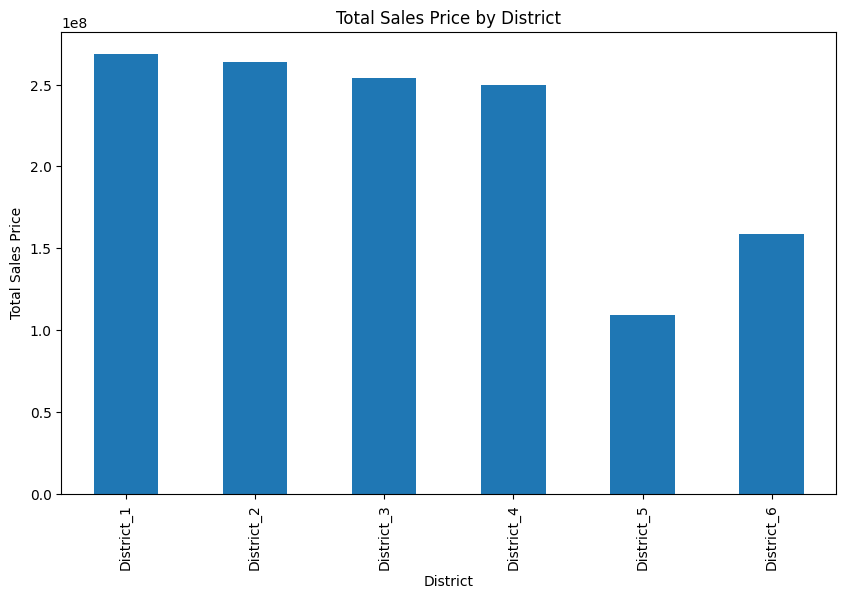

In [29]:
import matplotlib.pyplot as plt

df.groupby('District')['SalePrice'].sum().plot(kind='bar', figsize=(10, 6))
plt.title('Total Sales Price by District')
plt.ylabel('Total Sales Price')
plt.show()
